In [22]:
#Required Imports
import os # Configure which GPU 
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e) 

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we 
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    no_preview = True # deactivate preview
except:
    if os.getenv("SIONNA_NO_PREVIEW"):
        no_preview = True
    else:
        no_preview = False

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 42

# Other imports          
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np
import sys

import tensorflow as tf
from scipy.interpolate import interp1d
    
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera

from sionna.rt.antenna import Antenna, visualize
from sionna.constants import PI
from sionna.rt.antenna import polarization_model_2, polarization_model_1

Functions to read the .MSI file

In [23]:
def split_values(data):
    column2 = []
    for ii in data:
        temp1, temp2 = ii.strip().split()
        column2.append(float(temp2))

    np_column2 = np.array(column2)
    return np_column2
    
def importar_msi(archivo):
    with open(archivo, 'r') as f:
        lineas = f.readlines() # Reading all lines
        horizontal_data = split_values(lineas[6:366]) # processing h_data
        vertical_data = split_values(lineas[367:727]) # processing v_data

        temp, freq = lineas[1].strip().split()        # taking the frequency in MHz
        freq = float(freq)

        temp, gain, unit_dBd  = lineas[2].strip().split() # taking the gain in dBd (unit_dBd contains the unit)
        gain = float(gain) + 2.15 # converting to dBi
        
    # Regular expression
    return horizontal_data, vertical_data, freq, gain

In [26]:
#READING MSI FILE
archivo_msi = '80010465_0791_x_co.msi'
horizontal, vertical, freq, gain = importar_msi(archivo_msi)

print(f"Este es el tipo de variable de VERTICAL: {type(vertical)}")
print(f"Este es el tipo de variable de HORIZONTAL: {type(horizontal)}")

print(f'Este es el contenido de VERTICAL: {vertical}')
print(f'Este es el valor de gain: {gain}')

'''print(f'Este es el type de horizontal: {horizontal}')
print(f'Este es el type de vertical: {vertical}')'''

# Taking the positive x-side of the vertical plane, 1st and 4th quadrant: 
temp1 = vertical[0:91]
temp1 = temp1[::-1]
temp2 = vertical[270:360]
temp2 = temp2[::-1]
vertical_x_side = np.concatenate((temp1, temp2))
vertical = vertical_x_side

#Data in msi file is attenuation in dB, so the real gain is: G(angles) = Gain - MSI_DATA(angles)
g_hor_dB = gain - horizontal
g_ver_dB = gain - vertical #Remember, we selected 181 angles corresponding to first and fourth quadrant

# The normalized values in dB will be -MSI_DATA(angles)
g_hor_dB_n = - horizontal
g_ver_dB_n = - vertical 

#normalized gain from dB to lineal. Normalized values have been utilized, the gain factor will be added at the end.
gain_v = 10**(g_ver_dB_n/10)
gain_h_temp = 10**(g_hor_dB_n/10) #A temporal variable has been used because we are going to shift the angles to [-pi,pi)

theta = np.linspace(0, 2*np.pi, 360)
# Shift the theta values to range from -pi to pi
theta_shifted = np.where(theta > np.pi, theta - 2*np.pi, theta)
sorted_indices = np.argsort(theta_shifted)
gain_h = gain_h_temp[sorted_indices]

print(f"This is the VALUE of gain_h: {gain_h_temp}")
print(f"This is the SHAPE of gain_h: {np.shape(gain_h_temp)}")

print(f"\nThese are the values of the sorted_indices: {sorted_indices}")
print(f"\nThis is the shape of the variable: sorted_indices: {np.shape(sorted_indices)}")

# Once angles and gain in the MSI file has been parse to be aligned with the spherical coordinate 
# we can work with the variables (theta,phi).
theta_rad = np.linspace(0, np.pi, 181)  # Zenith angles
phi_rad = np.linspace(-np.pi, np.pi, 360)  # Azimuth angles

# Interpolation of each plane: It is required because we only have data with a resolution of one degree from the MSI file
interp_v = interp1d(theta_rad, gain_v, kind='linear', fill_value="extrapolate")
interp_h = interp1d(phi_rad, gain_h, kind='linear', fill_value="extrapolate")

# Custom antenna pattern function to be used in Sionna
def custom_pattern(theta, phi, slant_angle=0.0, polarization_model=2, dtype=tf.complex64):

    rdtype = dtype.real_dtype
    k_dB = gain  # IMPORTANT: the gain should be in dBi not in dBd (previous conversion has been done)
    #k_dB = 0    # Uncomment if you want to normalize the radiattion pattern
    k_dB = tf.cast(k_dB,rdtype)    
    k = 10**(k_dB/10)    
    theta = tf.cast(theta, rdtype)
    phi = tf.cast(phi, rdtype)
    slant_angle = tf.cast(slant_angle, rdtype) # This angle is associate with the polarization

    # Common for SIONNA: (IMPORTANTE) same shape does not mean same intervals: (0,pi) and (-pi,pi)
    if not theta.shape== phi.shape: 
        raise ValueError("theta and phi must have the same shape.")
    if polarization_model not in [1,2]:
        raise ValueError("polarization_model must be 1 or 2")

    
    #Use the interpolator to create a function for each plane
    gain_theta = tf.py_function(func=interp_v, inp=[theta], Tout=tf.float32)
    gain_phi = tf.py_function(func=interp_h, inp=[phi], Tout=tf.float32)

    # Estimation of the 3D pattern using summing algorithms: G_dBn(theta,phi) = G_dBn(theta) + G_dBn(phi)
    gain_theta_dB_n = 10.0 * tf.math.log(gain_theta) / tf.math.log(10.0)
    gain_phi_dB_n = 10.0 * tf.math.log(gain_phi) / tf.math.log(10.0)
    gain_theta_phi_dB_n = gain_theta_dB_n + gain_phi_dB_n
    # save the output in a variable
    np.save('gain_theta_phi_dB_n_ROLANDO_ALEJANDRO.npy', gain_theta_phi_dB_n)

    
    #Converting from dBn to linear
    g_theta_phi = tf.pow(10.0, gain_theta_phi_dB_n / 10.0) #normalized gain for each per (theta, phi) 
    
    # The values from the MSI files are gain/attenuation values (power)
    # We need to convert from power to field components F = sqrt(P)    
    temp = tf.sqrt(k)*tf.sqrt(g_theta_phi)             
    c = tf.complex(temp, tf.zeros_like(temp))

    # Common step in sionna, this functions obtain the Field components based on the slant angle
    if polarization_model==1:
        return polarization_model_1(c, theta, phi, slant_angle)
    else:
        return polarization_model_2(c, slant_angle)
    

# Create the antenna object
#antenna = Antenna(pattern=custom_pattern, polarization="VH", dtype=tf.complex64)

# Visualize the antenna pattern (optional)
#fig_v, fig_h, fig_3d = antenna.visualize(custom_pattern)

Este es el tipo de variable de VERTICAL: <class 'numpy.ndarray'>
Este es el tipo de variable de HORIZONTAL: <class 'numpy.ndarray'>
Este es el contenido de VERTICAL: [3.000e-02 1.000e-02 0.000e+00 2.000e-02 5.000e-02 1.100e-01 1.900e-01
 2.900e-01 4.100e-01 5.400e-01 6.800e-01 8.200e-01 9.700e-01 1.120e+00
 1.250e+00 1.380e+00 1.490e+00 1.580e+00 1.660e+00 1.720e+00 1.760e+00
 1.790e+00 1.800e+00 1.800e+00 1.790e+00 1.770e+00 1.740e+00 1.700e+00
 1.670e+00 1.630e+00 1.590e+00 1.550e+00 1.520e+00 1.500e+00 1.480e+00
 1.480e+00 1.480e+00 1.490e+00 1.510e+00 1.540e+00 1.560e+00 1.600e+00
 1.630e+00 1.650e+00 1.680e+00 1.700e+00 1.710e+00 1.730e+00 1.740e+00
 1.750e+00 1.770e+00 1.780e+00 1.810e+00 1.840e+00 1.870e+00 1.910e+00
 1.960e+00 2.010e+00 2.060e+00 2.110e+00 2.170e+00 2.230e+00 2.280e+00
 2.340e+00 2.400e+00 2.470e+00 2.540e+00 2.620e+00 2.710e+00 2.820e+00
 2.940e+00 3.070e+00 3.230e+00 3.400e+00 3.600e+00 3.810e+00 4.050e+00
 4.320e+00 4.610e+00 4.920e+00 5.260e+00 5.640e+00 6.

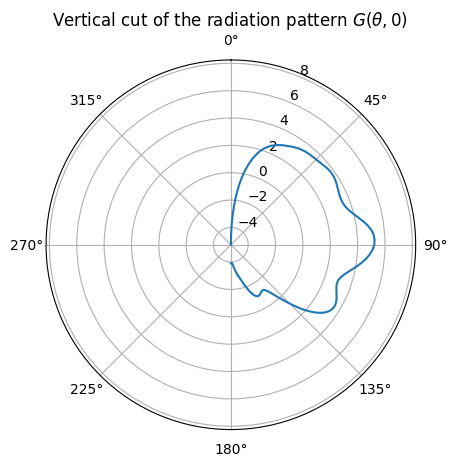

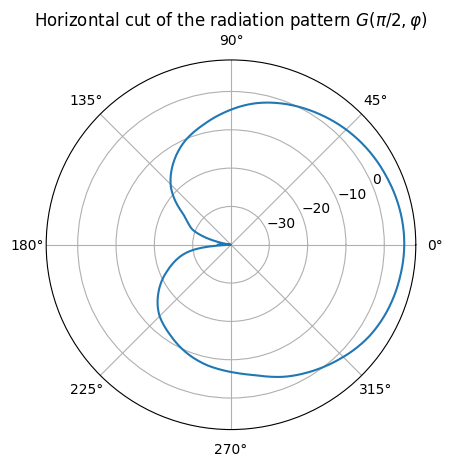

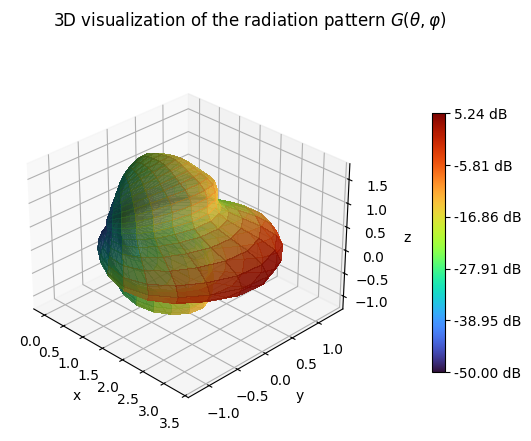

In [25]:
antenna = Antenna(pattern=custom_pattern, polarization="H", dtype=tf.complex64)

fig_v, fig_h, fig_3d = visualize(custom_pattern)